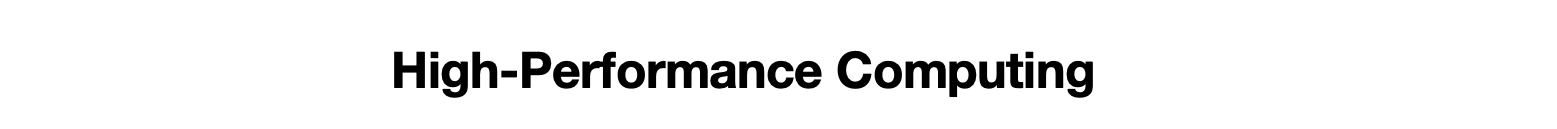

## 1) Choose the function or fragment of code you want to speed up

I've tried to speed up some functions from my course work [Warehouse optimization](https://github.com/anafisa/Warehouse-optimization). There were functions _ordering1, ordering2, ordering3._ These methods allows automaticly find the most efficient relocation of workes between floors and reduce significantly the total execution time of working shift.  

In [1]:
from data import waves, floors,  wave_floor_route, wave_workers
from route_time_calc import route_time, wave_time

In [2]:
def ordering1(n, routes, route_time):
    
    d = dict()
    new_time = [0] * n
    time = []

    for i in routes:
        d[route_time[i]] = i
        time.append(route_time[i])

    time = sorted(time, reverse=True)

    while time:
        for i in range(0, len(new_time)):
            if time:
                ind = new_time.index(min(new_time))
                new_time[ind] += time[0]
                time.remove(time[0])
            else:
                break
    return new_time       
                

In [3]:
def ordering3(wave, wave_workers,wave_floor_route, floors):
    
    workers = wave_workers[wave]
    k = workers // 2
    tt = [[], [], [], []]
    res = []
    rel = []

    for i in range(1, k):
        for j in floors:
            routes = wave_floor_route[wave][j]
            tt[int(j) - 1].append(max(ordering1(i, routes, route_time)))

    for i in range(1, len(tt[0]) + 1):
        for j in range(1, len(tt[1]) + 1):
            for g in range(1, len(tt[2]) + 1):
                for k in range(1, len(tt[3]) + 1):
                    if i + j + g + k == workers:
                        res.append(max(tt[0][i - 1], tt[1][j - 1], tt[2][g - 1], tt[3][k - 1]))
                        rel.append([i, j, g, k])

    ind = res.index(min(res))
    return [min(res), rel[ind]]

Let's check the execution time of functions 

In [4]:
def res():
    for wave in waves:
        return ordering3(wave, wave_workers,wave_floor_route, floors)

In [5]:
%timeit res()

21.9 ms ± 433 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 2) Attempts to speed up functions using Cython (without types)

In [6]:
%load_ext cython

In [7]:
%%cython -a 

def cython_ordering1(n, routes, route_time):
    
    d = dict()
    new_time = [0] * n
    time = []

    for i in routes:
        d[route_time[i]] = i
        time.append(route_time[i])

    time = sorted(time, reverse=True)

    while time:
        for i in range(0, len(new_time)):
            if time:
                ind = new_time.index(min(new_time))
                new_time[ind] += time[0]
                time.remove(time[0])
            else:
                break
                
    return new_time       
                

In [8]:
%%cython -a 

def cython_order(wave, wave_workers,wave_floor_route, floors, route_time,cython_ordering1):
    
    workers = wave_workers[wave]
    k = workers // 2
    tt = [[], [], [], []]
    res = []
    rel = []

    for i in range(1, k):
        for j in floors:
            routes = wave_floor_route[wave][j]
            tt[int(j) - 1].append(max(cython_ordering1(i, routes, route_time)))

    for i in range(1, len(tt[0]) + 1):
        for j in range(1, len(tt[1]) + 1):
            for g in range(1, len(tt[2]) + 1):
                for k in range(1, len(tt[3]) + 1):
                    if i + j + g + k == workers:
                        res.append(max(tt[0][i - 1], tt[1][j - 1], tt[2][g - 1], tt[3][k - 1]))
                        rel.append([i, j, g, k])

    ind = res.index(min(res))

    return [min(res), rel[ind]]

Let's check the execution time of functions using Cython

In [9]:
def res():
    for wave in waves:
        return cython_order(wave, wave_workers,wave_floor_route, floors,route_time, cython_ordering1)

In [10]:
%timeit res()

11.6 ms ± 281 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Cython (without types) allows to speed up Python functions almost in 2 times. At first we have 21.9 ms, now it's 11.6 ms. Great!